### Import libraries

In [1]:
import sys
import os
sys.path.append(os.path.abspath('../../'))

from evaluation import *
from data_loader import *
import random
from datetime import datetime

### Load data

In [2]:
experiments = [1, 2, 3]

exp_agent_data = []

for exp_num in experiments:
    config_fname = f'../Exp_{exp_num}/config.yaml'
    
    c = load_config_file(config_fname)
    nn_c = c['nn_hyperparameters']
    federated_c = c['federated_learning_settings']
    algo_c = c['algorithm_settings']
    env_c = c['environment_settings']
    eval_c = c['eval_config']
    
    verbose = eval_c['verbose']
    
    if eval_c['fixed_attributes'] != [0, 1] and eval_c['fixed_attributes'] != [1, 0] and eval_c['fixed_attributes'] != [0.5, 0.5]:
        attr_label = 'learned'
    else:
        fixed_attributes = eval_c['fixed_attributes']
        attr_label = f'{fixed_attributes[0]}_{fixed_attributes[1]}'
    
    current_datetime = datetime.now()
    date = current_datetime.strftime('%Y-%m-%d_%H-%M')

    ev_info = []

    seed = env_c['seed']
    
    # Assign seed
    random.seed(seed)
    # Creating and seeding a random generaton from Numpy
    rng = np.random.default_rng(seed)
    
    # Generate a random model index for each agent
    model_indices = np.array([random.randrange(3) for agent in range(env_c['num_of_cars'])], dtype=int)

    # Use the indices to select the model type and corresponding configurations
    model_type = np.array([env_c['models'][index] for index in model_indices], dtype=str)
    usage_per_hour = np.array([env_c['usage_per_hour'][index] for index in model_indices], dtype=int)
    max_charge = np.array([env_c['max_charge'][index] for index in model_indices], dtype=int)

    start_time = time.time()
    # Random charge between 0.5-x%, where x scales between 1-25% as sessions continue
    starting_charge = env_c['starting_charge'] + 2000*(rng.random(env_c['num_of_cars'])-0.5)
    elapsed_time = time.time() - start_time

    # Define a structured array
    dtypes = [('starting_charge', float),
                ('max_charge', int),
                ('usage_per_hour', int),
                ('model_type', 'U50'),  # Adjust string length as needed
                ('model_indices', int)]
    info = np.zeros(env_c['num_of_cars'], dtype=dtypes)

    # Assign values
    info['starting_charge'] = starting_charge
    info['max_charge'] = max_charge
    info['usage_per_hour'] = usage_per_hour
    info['model_type'] = model_type
    info['model_indices'] = model_indices

    ev_info.append(info)

    algorithm_dm = algo_c['algorithm']
    
    def load_from_json_with_error_handling(filepath):
        try:
            return read_csv_data(filepath)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON from {filepath}: {e.msg} at line {e.lineno}, column {e.colno}")
            return None  # Handle the error and return None or an empty object
    
    
    d_base = f"../../../../../storage_1/metrics/Exp_{exp_num}"
    
    if not os.path.exists(d_base):
        d_base = f"../metrics/Exp_{exp_num}"
            
    base_path = f"{d_base}/train/metrics"

    print(f'Loading {base_path}_agent_metrics.csv')
    agent_data = load_from_json_with_error_handling(f'{base_path}_agent_metrics.csv')
    agent_data['seed'] = seed

    exp_agent_data.append(agent_data)

Loading ../../../../../storage_1/metrics/Exp_1/train/metrics_agent_metrics.csv
Loading ../../../../../storage_1/metrics/Exp_2/train/metrics_agent_metrics.csv
Loading ../../../../../storage_1/metrics/Exp_3/train/metrics_agent_metrics.csv


### Modify reward data to be cumulative averages

In [3]:
# Convert data to DataFrame for easier manipulation
df = pd.concat(exp_agent_data, ignore_index=True)

# Create a new DataFrame that just has the cumulative reward per episode, zone, aggregation, agent_index, and seed
cumulative_reward_df = df.groupby(['episode', 'zone', 'aggregation', 'agent_index', 'seed'])['reward'].sum().reset_index()

# Rename the 'reward' column to 'cumulative_reward' for clarity
cumulative_reward_df.rename(columns={'reward': 'cumulative_reward'}, inplace=True)

# Get recalculated episodes using (aggregation number * episodes per aggregation) + episode number
cumulative_reward_df['episode'] = cumulative_reward_df['aggregation'] * nn_c['num_episodes'] + cumulative_reward_df['episode']

# Calculate cumulative average reward per episode and zone
cumulative_avg_reward_by_zone = cumulative_reward_df.groupby(['episode', 'zone', 'seed'])['cumulative_reward'].mean().reset_index()
cumulative_avg_reward_by_zone['cumulative_reward'] = cumulative_avg_reward_by_zone.groupby(['zone', 'seed'])['cumulative_reward'].expanding().mean().reset_index(level=[0, 1], drop=True)

### Plot data

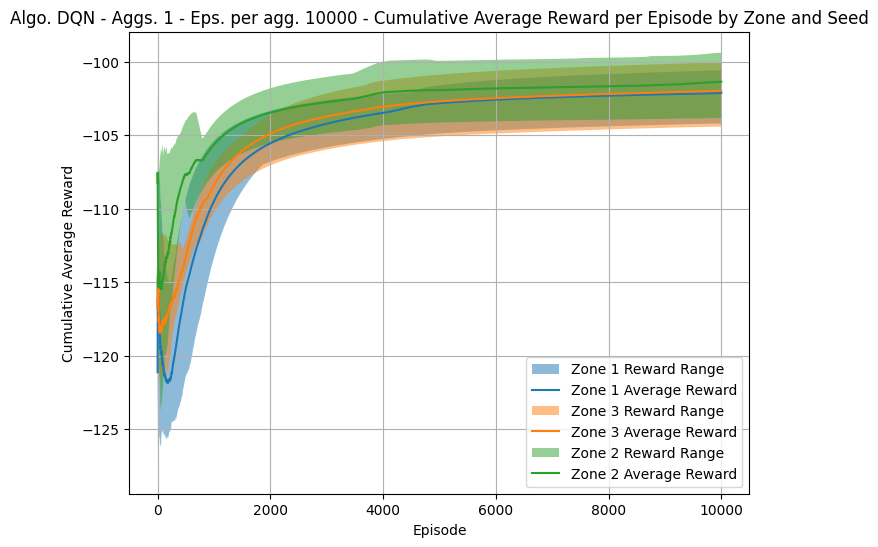

In [4]:
# Plot the cloud plot for each zone
plt.figure(figsize=(8, 6))
for zone in df['zone'].unique():
    # Filter the data for the current zone
    zone_data = cumulative_avg_reward_by_zone.loc[cumulative_avg_reward_by_zone['zone'] == zone]
    min_cumulative_avg_reward = zone_data.groupby('episode')['cumulative_reward'].min()
    max_cumulative_avg_reward = zone_data.groupby('episode')['cumulative_reward'].max()
    mean_cumulative_avg_reward = zone_data.groupby('episode')['cumulative_reward'].mean()

    plt.fill_between(
        min_cumulative_avg_reward.index, 
        min_cumulative_avg_reward.values, 
        max_cumulative_avg_reward.values, 
        alpha=0.5, label=f'Zone {zone} Reward Range'
    )
    plt.plot(
        mean_cumulative_avg_reward.index, 
        mean_cumulative_avg_reward.values, 
        label=f'Zone {zone} Average Reward'
    )

plt.xlabel('Episode')
plt.ylabel('Cumulative Average Reward')
plt.title(f'Algo. {algo_c["algorithm"]} - Aggs. {federated_c["aggregation_count"]} - Eps. per agg. {nn_c["num_episodes"]} - Cumulative Average Reward per Episode by Zone and Seed')
plt.legend()
plt.grid(True)
plt.show()